In [183]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from tqdm.auto import tqdm
from tqdm.notebook import tqdm as tqdm
tqdm.pandas() # Prep tqdm for pandas
import numpy as np
import re
import math
from scipy import stats
from collections import Counter

from statistics import stdev, mean, median

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import time
import os
import subprocess as subp
import re

from scipy import stats
from statsmodels.stats import multitest

from skbio.stats.composition import ilr, clr

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import random as rand

#Create a color scheme
sayf_colors = ["#1B4F72", "#641E16", "#7D6608", "#1B2631", "#E74C3C", "#9B59B6", "#2980B9",\
               "#1ABC9C", "#F1C40F", "#95A5A6", "#E67E22", "#2ECC71", "#85C1E9", "#D7BDE2",\
               "#4A235A", "#A3E4D7", "#784212", "#FCF3CF", "#F342DF", "#FFFD37", "#0A0A0A",\
               "#69FF00", "#ED9FEC", "#00FCFF", "#8E9EF2", "#FF1700"]

plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-notebook')
#sns.set_palette(sayf_colors)

#Create a color map as well
from matplotlib.colors import ListedColormap
sayf_cmap = ListedColormap(sayf_colors[5:])

# Turn off the SettingWithCopy warning
pd.set_option('mode.chained_assignment', None)

/home/sayf/.local/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Taxonomic analysis

## Import the relative abundance data

- hmp: Human Microbiome Project samples (external healthy control)
    - Known as Healthy-1 cohort in manuscript
    - Obtained from Human microbiome project data portal<sup>1</sup> (https://portal.hmpdacc.org/)
    
- ibd: Inflammatory Bowel Disease samples
    - Contains IBD samples that are not dysbiotic
    - From IBDMDB publication<sup>2</sup>
    
- nibd: Non-IBD samples (internal healthy control)
    - Contains samples found to not have IBD but not necessarily healthy
    - Obtained from IBDMDB publication<sup>2</sup>

- kns: 'Knights' (external healthy control)
    - Healthy college-aged students from University of Minnesota from Abigail et al 2019<sup>3</sup>
    
<br>

- Citations
    1. Peterson J, Garges S, Giovanni M, McInnes P, Wang L, Schloss JA, et al. The NIH Human Microbiome Project. Genome Res. 2009;19(12):2317–23.
    2. Schirmer, Melanie, et al. "Dynamics of metatranscription in the inflammatory bowel disease gut microbiome." Nature microbiology 3.3 (2018): 337-346.
    3. Johnson, Abigail J., et al. "Daily sampling reveals personalized diet-microbiome associations in humans." Cell host & microbe 25.6 (2019): 789-802.

In [10]:
# Import the 0 prevalence strain data so we can slice based on union and roll-back
hmp0 = pd.read_csv("DataFiles/Dataframes/Originals/HMP2_Strains(plasmid-free).tsv", sep="\t", index_col="SampleName")
hmp0["Dysbiotic_Status"] = False
hmp0["Diagnosis"] = "Healthy"

ibd0 = pd.read_csv("DataFiles/Dataframes/Originals/IBDN_Dup_Strains(plasmid-free).tsv", 
                   sep="\t")
ibd0["SampleName"] = ibd0.SampleName.apply(lambda x:x.split("_")[0])
ibd0.set_index("SampleName", inplace=True)

# Correct sample naming scheme
nibd0 = pd.read_csv("DataFiles/Dataframes/Originals/nonIBD2_Strains(plasmid-free).tsv", sep="\t")
nibd0["SampleName"] = nibd0.SampleName.apply(lambda x:x.split("_")[0])
nibd0.set_index("SampleName", inplace=True)

kns0 = pd.read_csv("DataFiles/Dataframes/Originals/KHealthyStrains(plasmid-free).tsv", sep="\t")
kns0["SampleName"] = kns0.SampleName.apply(lambda x:x.split("_R1")[0])
kns0["Dysbiotic_Status"] = False
kns0["Diagnosis"] = "Healthy"
kns0.set_index("SampleName", inplace=True)

print(f"HMP: {hmp0.shape}")
print(f"IBD: {ibd0.shape}")
print(f"nIBD: {nibd0.shape}")
print(f"Knights: {kns0.shape}")

# Import the IBDMDB metadata
ibd_meta = pd.read_csv("DataFiles/Complete_IBDMDB_Metadata2.tsv", sep="\t")

ibd_meta["SampleName"] = ibd_meta["Unnamed: 0"].apply(lambda x:x.split("_")[0])
ibd_meta.set_index("SampleName", inplace=True)
ibd_meta.drop("Unnamed: 0", inplace=True, axis=1)

# Add the meta data to the relative abundance data
ibd0 = ibd0.join(ibd_meta)
ibd0 = ibd0[~ibd0.index.duplicated(keep='first')]

nibd0 = nibd0.join(ibd_meta)
nibd0 = nibd0[~nibd0.index.duplicated(keep='first')]

HMP: (203, 19688)
IBD: (210, 10839)
nIBD: (49, 10839)
Knights: (114, 10841)


## Prevalence and noise thresholding
    1. Select bacterial species by prevalence
        - Done on a cohort by cohort basis
    2. Remove bacterial species that fall below a 'noise' threhsold
        - 'Noise' threshold at 1e-5

## Pre-process the data

In [184]:
# Remove noisy reads
def RemoveNoise(df, noise_thresh=1e-5):
    """
    Function to remove the noisry read values

    Parameters
    ----------
    df: DataFrame object
    noise_thresh: Minimum relative abundance value

    Returns
    -------
    DF containing the cleaned reads

    """

    wdf = df.select_dtypes("float64").copy() # Make sure to only work on the relative abundances

    print(f"Removing all strains with max < {noise_thresh} relative abundance")
    drop_cols = [x for x in wdf.progress_apply(lambda x:"pass" if x.max() > noise_thresh else x.name) if x != "pass"]
    wdf.drop(drop_cols, axis=1, inplace=True)

    # Replace values lower than the threshold with zeros
    print(f"Replacing remaining values with 0's")
    for col in tqdm(wdf.columns):
        wdf[col] = wdf[col].apply(lambda x:x if x > noise_thresh else np.nan)

    return wdf

# Roll back the species
def RollBack(df):
    """
    Function to roll the strain-level data up to species-level

    Parameters
    ----------
    df: Dataframe containing strain-level data

    Returns
    -------
    DF containing species-level ID's
    """

    dfs = df.copy()

    print("Rolling back to species-level")
    for i in tqdm(dfs.columns):

        if "_" not in i:
            pass

        else:
            seps = "_"
            try:
                if "endosymbiont" in i:
                    pass
                elif i.split(sep="_", maxsplit=2)[1].lower() == 'sp':
                    j = seps.join([i.split(sep="_", maxsplit=2)[0], i.split(sep="_", maxsplit=3)[1], i.split(sep="_", maxsplit=3)[2]])
                    dfs.rename(columns={i:j}, inplace=True)
                else:
                    j = seps.join([i.split(sep="_", maxsplit=2)[0], i.split(sep="_", maxsplit=2)[1]])
                    dfs.rename(columns={i:j}, inplace=True)
            except:
                j = seps.join([i.split(sep="_", maxsplit=2)[0], i.split(sep="_", maxsplit=2)[1], "Unidentified"])

    #Sum the species up
    df_specs = dfs.groupby(by=dfs.columns, axis=1).sum()

    #Write out the species-level df
    return df_specs

# Use a prevalence threhsold
def PrevThershold(df, prev_thresh=0.9):
    """
    Function to threshold bacteria based on prevalence

    Parameters
    ----------
    df: DF
    prev_thresh: Prevalence threshold as a decimal (e.g. 90% == 0.9)

    Returns
    -------
    DF with the bacteria over the provided prevalence threshold

    """
    wdf = df.replace(0, np.nan)

    prev = prev_thresh * len(wdf)
    wdf.dropna(thresh=prev, axis=1, inplace=True)

    return wdf.apply(lambda x:x/x.sum(), axis=1)

def SumCheck(df):
        pcnt = 0
        for i in df.index:
            s = np.sum(df.loc[i].values)
            if s < 0.99:
                print("{} failed check; sum={}".format(i, s))
            else: 
                pcnt+=1
        print("\n{}/{} samples pass sum_check\n"\
              .format(pcnt, len(df.index)))
        
def DataTrans(df, method):
    """
    Function to conduct ILR transformation on given data
    
    Parameters
    ----------
    df: Dataframe containing the data for transformation
    method: String specifying 'clr' or 'ilr'
    
    Returns
    -------
    DF with log-ratio transformed data
    
    """
    
    wdf = df.select_dtypes("float64").copy() #Working DF
    
    #Replace 0's with very small numbers
    trans_df = wdf.apply(lambda x:x.replace(0, 1e-10))
    
    if method == 'ilr':
        #Tranform the data and turn into a DF
        ilr_df = pd.DataFrame(ilr(trans_df),\
                          columns=list(trans_df.columns)[:-1],\
                          index=list(trans_df.index.values))
        
        return ilr_df
    
    elif method == 'clr':
        #Tranform the data and turn into a DF
        clr_df = pd.DataFrame(clr(trans_df),\
                          columns=list(trans_df.columns),\
                          index=list(trans_df.index.values))
        
        return clr_df

    
def PreProcess(df, noise_thresh=1e-5, prev_thresh=0.9, roll_up=True):
    """
    Function to pre-process the data

    Parameters
    ----------
    df: DataFrame object
    noise_thresh: Minimum relative abundance value
    prev_thresh: Prevalence threshold as a decimal (e.g. 90% == 0.9)
    roll_up: Boolean to denote if you wish to roll-strains up to species-level

    Returns
    -------
    DF containing the cleaned reads

    """
    
    cdf = RemoveNoise(df, noise_thresh) # Cleaned DF
    
    if roll_up:
        rdf = RollBack(cdf) # Rolled-back DF
        pdf = PrevThershold(rdf, prev_thresh) # Prevalence DF
    else:
        pdf = PrevThershold(cdf, prev_thresh) # Prevalence DF
    
    SumCheck(pdf)
    
    return pdf

In [12]:
# Import the data for the union of the 90% prevalence species in each group (hmp, ibd, nibd, kns)
df = pd.read_csv("DataFiles/AllCohortsUnion90.csv")
df.shape

(574, 143)

## Diversity analysis
- Alpha-diversity was calculated using Shannon entropy (H)
    - $H = - \sum\limits_{i=1}^{n} p_i \times log(p_i)$
        - $p_i$ = proportion of species _i_ within sample
        - _n_ = number of species within sample     

In [185]:
def ShannonEntropy(df):
    """
    Function to return Shannon Entropy values for entire DF as a list
    
    Parameters
    ----------
    df: Dataframe object
    
    Returns
    -------
    List containing Shannon entropy values
    """
    
    # Select only numeric values
    wdf = df.select_dtypes("float64").replace(0, np.nan).copy()
    
    # Create a list of the Shannon entropies
    SE = [-1 * np.sum((wdf.loc[x] * np.log2(wdf.loc[x]))) for x in wdf.index]
    
    return SE

In [14]:
# Import the raw relative abundances
rra = pd.read_csv("./DataFiles/raw-relative-abundances.csv", index_col="SampleName")

# Add in the ShannonEntropy values
rra["ShannonEntropy"] = ShannonEntropy(rra)

# Split up the groups to make comparisons easier to read
ibd_se = rra[(rra.diagnosis == "UC") | (rra.diagnosis == "CD")].ShannonEntropy # IBD Shannon entropies

nibd_se = rra[rra.diagnosis == "UC"].ShannonEntropy # non-IBD Shannon entropies

h1_se = rra[rra.diagnosis == "Healthy-1"].ShannonEntropy # Healthy-1 cohort Shannon entropies
h2_se = rra[rra.diagnosis == "Healthy-2"].ShannonEntropy # Healthy-2 cohort Shannon entropies

In [15]:
# Compare the different groups to each other
print("\nCompare IBD to non-IBD")
print(stats.mannwhitneyu(ibd_se, nibd_se))

print("\nCompare IBD to Healthy-1")
print(stats.mannwhitneyu(ibd_se, h1_se))

print("\nCompare IBD to Healthy-2")
print(stats.mannwhitneyu(ibd_se, h2_se))

print("\nCompare non-IBD to Healthy-1")
print(stats.mannwhitneyu(nibd_se, h1_se))

print("\nCompare non-IBD to Healthy-2")
print(stats.mannwhitneyu(nibd_se, h2_se))


Compare IBD to non-IBD
MannwhitneyuResult(statistic=8104.5, pvalue=0.13204423322176562)

Compare IBD to Healthy-1
MannwhitneyuResult(statistic=2044.0, pvalue=8.728465705811876e-57)

Compare IBD to Healthy-2
MannwhitneyuResult(statistic=0.0, pvalue=4.055849522105681e-50)

Compare non-IBD to Healthy-1
MannwhitneyuResult(statistic=824.0, pvalue=5.000580647905565e-34)

Compare non-IBD to Healthy-2
MannwhitneyuResult(statistic=0.0, pvalue=9.140525978463001e-34)


## Identifying important species

- Random Forest Classifier was used to identify important features
    - Important features iare defined as features with a feature importance that is higher and significantly different than a random noise column
    
    <br>
- **Framework**
    1. A Gaussian distribution is modeled using the given data
    2. A random noise column is created by randomly picking from the Gaussian in the previous step
        * For each iteration, a new random noise column is created
    3. Bacterial species with mean feature importances higher than the random noise were retained
        * This is due to Mann-Whitney U test only designating whether two samples belong to different distributions; this allows us to determine samples that are higher and significntly different rather than just different which may include species with lower importance
    4. The retained species were then compared to the random column via a Mann-Whitney U (MWU) test
    5. The Benjamini-Hochberg multi-test correction was then performed on the MWU p-values and species with q-value (multi-test corrected p-value) < 0.05 were retained as the important species

In [186]:
def RFC_FI(trans_df, n, top_model_name, save, label, top_n=20, out=False, dpi=200, alpha=0.05):
    """Function to run a random forest classifier on transformed data n times and find the feature importances
    
    Paramters
    ---------
    trans_df: Dataframe containing transformed data
    n: Integer specifying how many times to re-run the classifier
    top_model_name: String specifying name to save the top-performing model as (without suffix)
    top_n: Integer specifying the top-n feature importances to show
    save: Boolean specifying whether to save the image or not
    label: Column to use to label the data
    out: String to save image as
    dpi: Integer specifying dpi of saved image
    alpha: The alpha level for determining if a feature is important
    
    Returns
    -------
    F-1 Scores for each run as global object stored as totals
    Image for top-n feature importances
    DF containing the feature importance of the important features
    
    """
    
    from sklearn.preprocessing import LabelEncoder
    from collections import defaultdict
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier as rfc
    import datetime as dt
    import random
    from scipy.stats import mannwhitneyu as MWU
    import statsmodels.stats.multitest


    edf = trans_df.copy()

    x = edf.drop(label, axis=1).select_dtypes("float64")
    y = edf[label].values

    # Create values that are normally distributed with the mean and SD of the data we have and add them in
    dist_mean = np.mean(x.apply(lambda x:x.mean()))
    dist_sd = np.std(x.apply(lambda x:x.std()))
    x["random"] = [random.gauss(mu=dist_mean, sigma=dist_sd) for x in range(len(trans_df))]


    global ytest
    xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.3)

    # Store accuracies
    global totals
    totals = {0:0}

    runs = 0

    #START LOOP

    print("Starting RFC\n")

    time0 = time.time()

    for i in range(n):
        runs +=1
        time1 = time.time()

        seed = dt.datetime.now().microsecond
        rf = rfc(n_estimators=100, random_state=seed)
        rf.fit(xtrain, ytrain)
        predicts = rf.predict(xtest)

        s = round(rf.score(xtest, ytest),4)

        if s > max(totals.values()) :
            pickle.dump(rf, open(top_model_name+'.sav', 'wb'))

        totals[i] = s

        print(" Run {} of {} Completed -- Score = {} -- TimeForLoop = {} seconds".format(
            runs, n, s, round((time.time() - time1),4)), end="\r")

        #Create a dataframe that houses the feature importances
        global all_imps
        imps = pd.DataFrame(rf.feature_importances_, columns=[f"Run{runs}"], index=xtrain.columns)

        if runs == 1:
            all_imps = imps
        else:
            all_imps[f"Run{runs}"] = imps[f"Run{runs}"]

    #END LOOP
    end_time = time.time() - time0
    if end_time > 60:
        end_time_stream = f"{round(end_time/60,2)} mins"
    else:
        end_time_stream = f"{end_time} seconds"

    print("\n\nRFC complete in {}. Top model saved as '{}.sav'.".format(end_time_stream, top_model_name))

    # Examine the found important features
#     global important_features_dict, important_features, sig_imps, mwu_results
    global important_features_dict
    important_features_dict = dict(all_imps.apply(lambda x:(round(x.mean(), 4), round(x.std(), 4)) \
                   if x.mean() >= all_imps.loc["random"].mean() \
                   else np.nan, axis=1).dropna())

    
    important_features = [x for x in important_features_dict.keys() if x != "random"]
    
    mwu_results = {} # Feature: P-val
    for feature in important_features:
        p_val = MWU(x=all_imps.T[feature], y=all_imps.T["random"])[1]
        mwu_results[feature] = [all_imps.T[feature].mean(), p_val]
    
    sig_imps = [x for x in mwu_results.keys() if mwu_results[x][1] < alpha]
    
    print(f"\n{len(sig_imps)} important features were found\n")
    
    # Make a DF out of the importances and analysis
    imp_analysis = pd.DataFrame.from_dict(mwu_results, orient='index', 
                                          columns = ["Importance", "P-val"])
    
    # Perform FDR correction
    if len(important_features) > 20:
        imp_analysis["Q-val"] = multitest.multipletests(imp_analysis["P-val"].values, 
                                                    method="fdr_bh")[1]
        
        imp_analysis = imp_analysis[imp_analysis["Q-val"] < alpha]
        
    else:
        imp_analysis = imp_analysis[imp_analysis["P-val"] < alpha]
        

    #Find feature importances
    global rf1
    rf1 = pickle.load(open(top_model_name+'.sav', 'rb')) #Load the highest performing classifier
    rf1.fit(xtrain, ytrain)
    global predicts1
    predicts1 = rf1.predict(xtest)
    
    global class_report
    class_report = classification_report(ytest, predicts1)
    
    print(class_report)
    
    print(f"Random column mean: {all_imps.loc['random'].mean()}")
    return imp_analysis

In [187]:
# imps = RFC_FI(df, n=500, top_model_name="all_nondys_diagnosis", save=False, label="diagnosis")

# Save totals to a csv
# pd.DataFrame.from_dict(totals, orient='index', columns=["F1-score"]).to_csv("all_nondys_diagnosis_totals.csv")

# Save the importances
# imps.to_csv("all_nondys_diagnosis_imps.csv")


"""
Model Results
-------------
RFC complete in 4.07 mins. Top model saved as 'all_nondys_diagnosis.sav'.
133 important features were found
Random column mean: 0.003095620582609224
"""

model = pickle.load(open("DataFiles/all_nondys_diagnosis.sav", 'rb')) #Load the highest performing classifier
imps = pd.read_csv("DataFiles/all_nondys_diagnosis_imps.csv", index_col="Unnamed: 0")
scores = pd.read_csv("DataFiles/all_nondys_diagnosis_totals.csv", index_col="Unnamed: 0")

## Differential abundance species analysis

In [188]:
def StatAnalysis(trans_df, label, group1, group2, alpha=0.05):
    """
    Function to find significant differences between the groups
    
    Determines if a sample is normally distributed and then conductes the appropriate pair-wise test.
    Mann-Whitney U test for non-parametric.
    Two-Sample T-test for parametric data.
    
    Parameters
    ----------
    df: Dataframe containing the transformed data for both groups
    group1: name of group1 as it appears in the dataframe
    group2: name of group2 as it appears in the dataframe
    alpha: cut-off for p-value
    
    Returns
    -------
    DF containing the results
    """
    
    df = trans_df.copy()
    
    dct = {} #To store information and turn into DF at the end
    #dct[i] = group1_norm, group2_norm, pval
    
    #Test for normality using D'Agostino Omnibus test
    for i in df.select_dtypes("float64"):
        
        if stats.normaltest(df[i][df[label] == group1])[1] > alpha:
            n1 = "Parametric"
        else:
            n1 = "Non-parametric"
        
        if stats.normaltest(df[i][df[label] == group2])[1] > alpha:
            n2 = "Parametric"
        else:
            n2 = "Non-parametric"
            
        
        #Perform correct pair-wise analysis
        if n1 == "Non-parametric" or n2 == "Non-parametric":
            try:
                pval = stats.mannwhitneyu(df[i][df[label] == group1].values,\
                                          df[i][df[label] == group2].values)[1]
            except ValueError:
                pval = int(1)
            
        else:
            pval = stats.ttest_ind(df[i][df[label] == group1].values,\
                                   df[i][df[label] == group2].values)[1]
            

        #Store the data
        dct[i] = [n1, n2,\
                  df[i][df[label] == group1].mean(), df[i][df[label] == group2].mean(),pval]
    
    norm1 = "{}_dist".format(group1)
    norm2 = "{}_dist".format(group2)
    mean1 = "{}_mean".format(group1)
    mean2 = "{}_mean".format(group2)
    
    
    #Create the analysis dataframe
    adf = pd.DataFrame.from_dict(dct, orient="index",\
                                 columns=[norm1, norm2, mean1, mean2, "P_value"])
    
    #Perform FDR correction
    adf["Q_value"] = multitest.multipletests(adf.P_value, method="fdr_bh")[1]
    
    print("Total samples: {}".format(len(adf)))
    
    print("P < 0.05: {}"\
      .format(len(adf[adf.P_value < 0.05])))

    print("Q < 0.05: {}"\
      .format(len(adf[adf.Q_value < 0.05])))
    
    return adf.sort_values(by="Q_value", ascending=True)

In [19]:
def DiffViz(df, alpha=0.05, fold_diff_thresh=2, out=None, save=False, dpi=200, fc_df_out=False):
    """
    Function to calculate and visualize top-20 differences between the ILR-transformed data
    
    Paramters
    ---------
    df: Dataframe containing the statistical analysis
    alpha: q-value cut-off for significance
    diff_thresh: Absolute value for minimum difference
    title_label: String for image title
    out: String containing the image name
    save: Boolean for saving the image
    dpi: Integer specifiying the image DPI
    fc_df_out: Boolean to return the fold-change df
    
    Returns
    -------
    Image display (Top-n differencnes with q-val > alpha and diff > thresh)
    Saved image
    fc_df: fold-change DF containg only the significantly different Fold-Changes
    """
    
    wdf = df.copy() #working df
    diff_thresh = math.log(fold_diff_thresh)
            
    ######################Create the diffs (log fold-change)#####################################
    #1: find the rows containing the means
    rm = re.compile("_mean")
    mean_list = list(filter(rm.search,list(wdf.columns)))

    g1, g2 = mean_list #Store the groups into variables for easy use

    #2: Find the differences
    wdf["Diff"] = wdf.apply(lambda x:x[g1] - x[g2]\
                                     if x[g1]-x[g2] != 0\
                                     else 0, axis=1)
    
    wdf["abs"] = abs(wdf["Diff"])
    wdf.sort_values(by='abs', ascending=False, inplace=True)
    wdf.drop("abs", axis=1, inplace=True)
    
    fc_df = wdf[wdf.Q_value < alpha]
    
    ##################Create the fold-change graph##############################################
    mask1 = fc_df.Diff > diff_thresh #Higher in HMP -- Lower in IBD
    mask2 = fc_df.Diff < -1*diff_thresh #Lower in HMP -- Higher in IBD
    
    #Draw the graph labels
    name1 = g1.split("_")[0]
    name2 = g2.split("_")[0]
    
    plt.figure(figsize=(24,12))
    
    plot_len = len(fc_df[mask1].index) + len(fc_df[mask2].index) + 3 # Make this the length of the plot
    plt.xlim(-3, plot_len)
    plt.bar(fc_df.index[mask1], fc_df.Diff[mask1], color='green', 
            label=name1, edgecolor='black', linewidth=1)
    plt.bar(fc_df.index[mask2], fc_df.Diff[mask2], color='red', 
            label=name2, edgecolor='black', linewidth=1)
    
    
    plt.title(f"Log-ratio differences between {name1} and {name2} of at least {fold_diff_thresh}-fold difference\n", 
              size=20, weight='bold')
    plt.ylabel(r"Difference in Log-ratios (base $e$)"+"\n", size=22)
    
    #Remove the x-ticks
    plt.tick_params(axis='x', bottom=False, labelbottom=False)
    
    #Draw the labels and asterisks on the graph
    #Pos labels
    x = 0.2
    for i in fc_df[mask1].index:
        try:
            if i.split("_strain")[0].split("_")[-1] in i.split("_strain")[1] or i.split("_strain")[0].split("_")[-3] in i.split("_strain")[1]:
                plt.annotate(i.split("_strain")[0], xy=(x,-0.2), rotation=60, ha='right', va='top',\
                        color='k', size=15)
            else:
                plt.annotate(i, xy=(x,-0.1), rotation=60, ha='right', va='top',\
                    color='k', size=15)
                
        except IndexError:
            plt.annotate(i, xy=(x,-0.1), rotation=60, ha='right', va='top',\
                    color='k', size=15)
            
        
        #Add q-value asterisks
        q = fc_df.loc[i]["Q_value"]
        y = fc_df.loc[i]["Diff"]
        
        if q < 0.001:
            s = "***"
        elif q < 0.01:
            s = "**"
        else:
            s = "*"
        
        plt.annotate(s, xy=(x-0.2,y), ha='center', va='bottom', size=18)
        
        x+=1
        
        
    #Neg labels
    for i in fc_df[mask2].index:
        try:
            if i.split("_strain")[0].split("_")[-1] in i.split("_strain")[1] or i.split("_strain")[0].split("_")[-3] in i.split("_strain")[1]:
                plt.annotate(i.split("_strain")[0], xy=(x-0.5,0.2), rotation=60, ha='left', va='bottom',\
                        color='k', size=15)
            else:
                plt.annotate(i, xy=(x-0.5,0.1), rotation=60, ha='left', va='bottom',\
                    color='k', size=15)
                
        except IndexError:
            plt.annotate(i, xy=(x-0.5,0.1), rotation=60, ha='left', va='bottom',\
                    color='k', size=15)
        
        #Add q-value asterisks
        q = fc_df.loc[i]["Q_value"]
        y = fc_df.loc[i]["Diff"]
        
        if q < 0.001:
            s = "***"
        elif q < 0.01:
            s = "**"
        else:
            s = "*"
        
        plt.annotate(s, xy=(x-0.2,y-0.05), ha='center', va='top', size=18)
        
        x+=1
    
    
    # Label how many bacs are up, and how many are down
    xmin, xmax, ymin, ymax  = plt.axis()
    
    plt.text(x=len(fc_df[mask1].index)/2, y=ymax-0.5, s=f"{len(fc_df[mask1])} bacteria", 
             color='darkgreen', size=20, bbox={"facecolor":"white", "edgecolor":"k"})
    
    plt.text(x=len(fc_df[mask2].index), y=ymin+0.5, s=f"{len(fc_df[mask2])} bacteria", 
             color='maroon', size=20, bbox={"facecolor":"white", "edgecolor":"k"})
    
    #Add note explaining the q-value asterisks
    plt.text(x=xmin+2, y=ymin+0.5, s="""* indicates a q-value < 0.05
** indicates a q-value < 0.01
*** indicates a q-value < 0.001""", bbox={'facecolor':'wheat'}, size=20)
    
    #Set up the save-option
    plt.tight_layout()
    
    if save:
        if not out:
            print("Out name required if you wish to save image")
        else:
            print("Image saved as '{}'".format(out))
            plt.savefig(out, dpi=dpi)
    
    plt.xticks(size=15)
    plt.yticks(size=15)
    
    plt.legend(frameon=True, facecolor="white", 
              prop={"size":20}, ncol=2)
#     plt.show()
    
    if fc_df_out:
        return fc_df

In [20]:
cdf = df.copy()
cdf["diagnosis"] = df.apply(lambda x:"Healthy-1" \
                                      if x["Cohort"] == "HMP" \
                                       else ("Healthy-2" if x["Cohort"] == "Knights" \
                                             else ("IBD" if x["diagnosis"] != "nonIBD" \
                                                   else x["diagnosis"])), axis=1)
display(cdf.diagnosis.value_counts())

IBD          208
Healthy-1    203
Healthy-2    114
nonIBD        49
Name: diagnosis, dtype: int64

Total samples: 138
P < 0.05: 72
Q < 0.05: 61


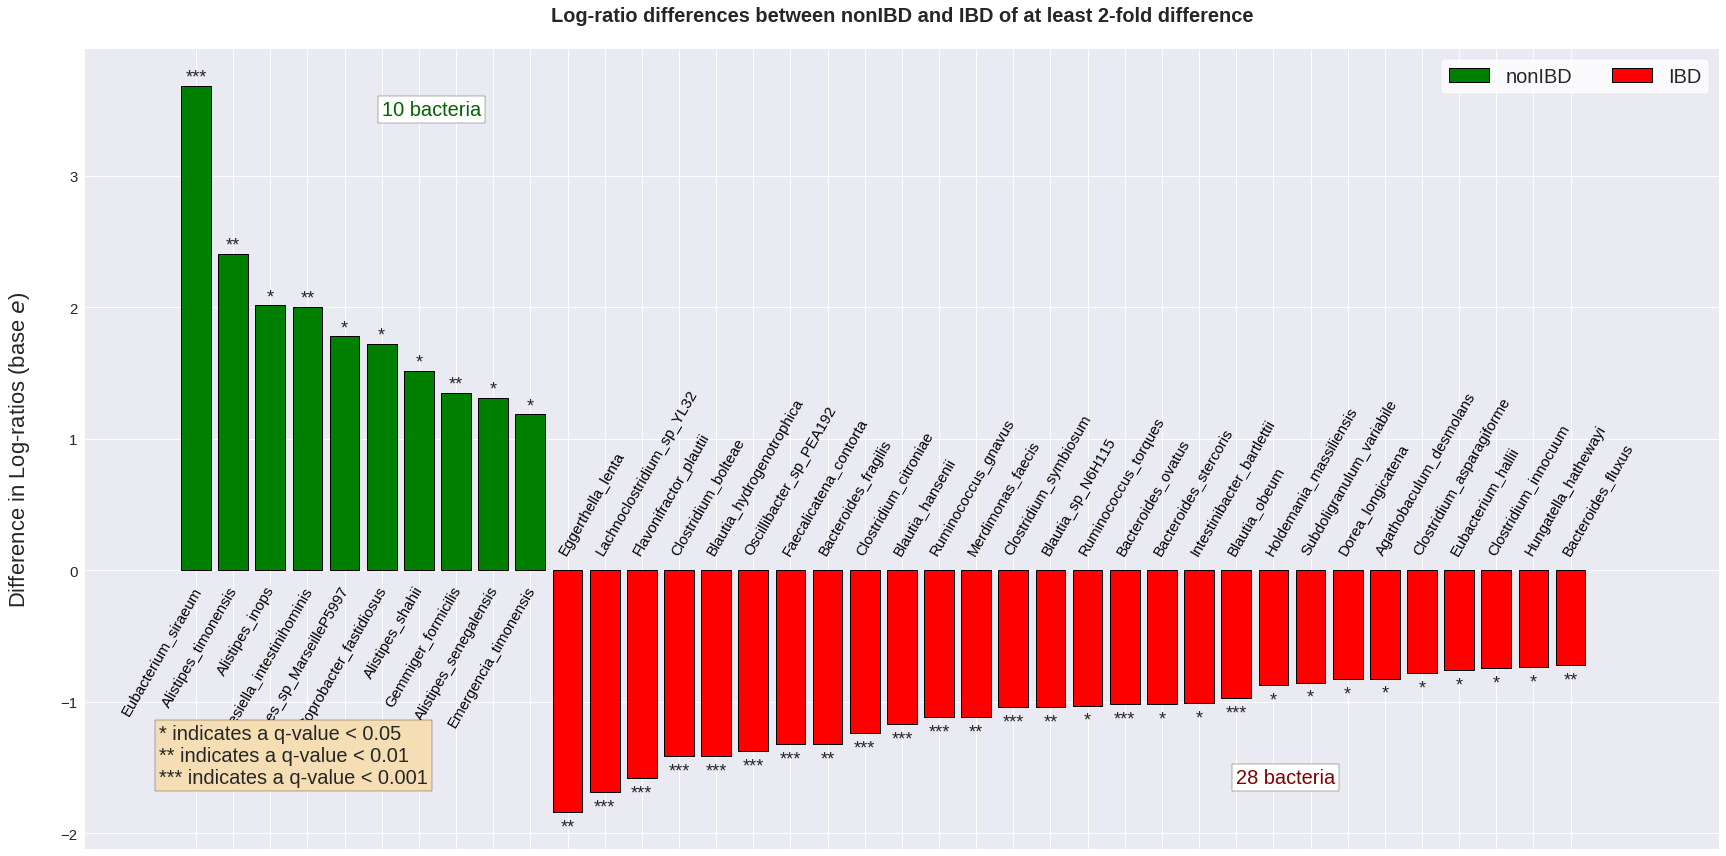

In [21]:
# Analyze the differential abundances of species between IBD and non-IBD
stat_ibdmdb = StatAnalysis(cdf, label="diagnosis", group1="nonIBD", group2="IBD")
DiffViz(stat_ibdmdb, fold_diff_thresh=2)

Total samples: 138
P < 0.05: 108
Q < 0.05: 103


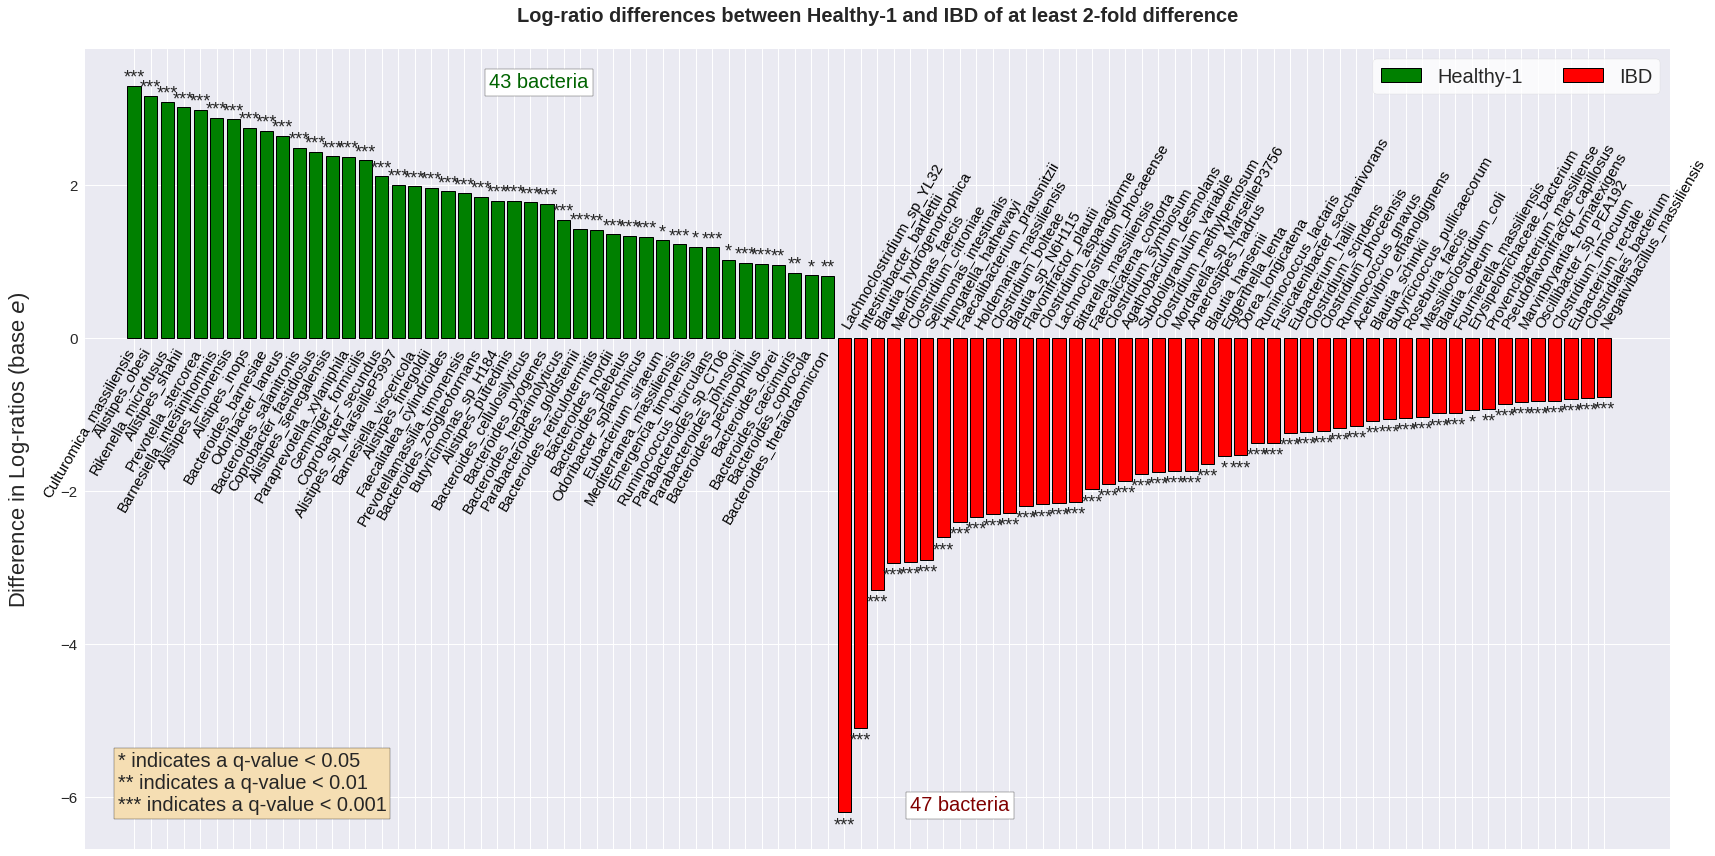

In [22]:
stat_ibd_healthy = StatAnalysis(cdf, label="diagnosis", group1="Healthy-1", group2="IBD")
DiffViz(stat_ibd_healthy, fold_diff_thresh=2)

Total samples: 138
P < 0.05: 112
Q < 0.05: 111


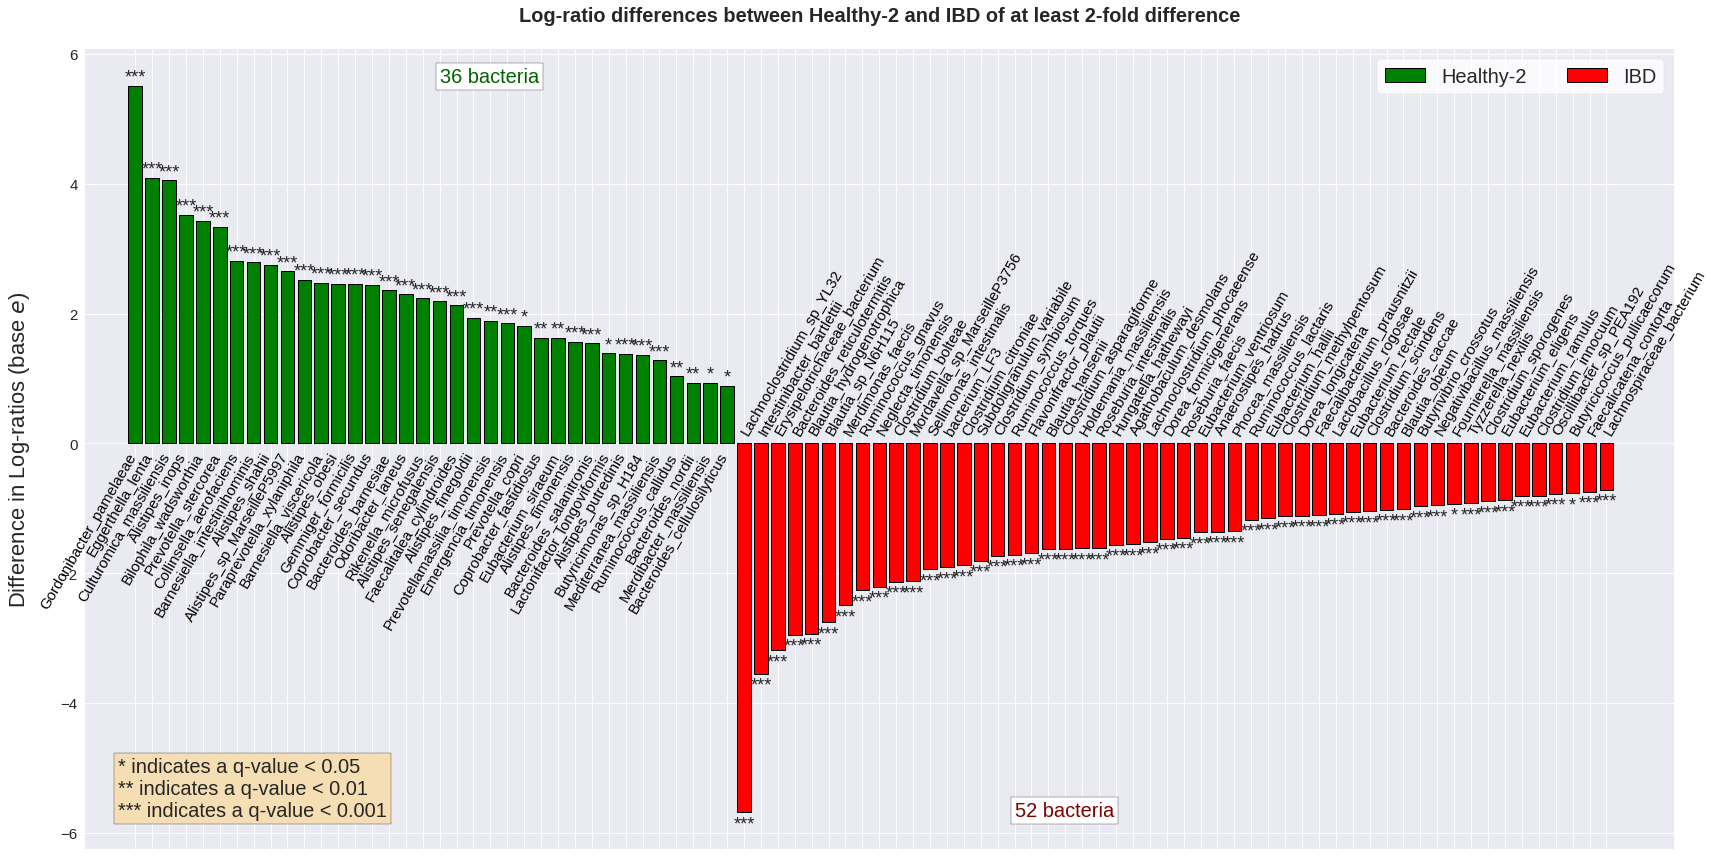

In [23]:
stat_ibd_kns = StatAnalysis(cdf, label="diagnosis", group1="Healthy-2", group2="IBD")
DiffViz(stat_ibd_kns, fold_diff_thresh=2)

In [191]:
# Average the 3 healthy groups (non-IBD, H1, H2) for ease of visualization
validated_bacs = [x for x in stat_ibdmdb[stat_ibdmdb.Q_value < 0.05].index \
 if x in stat_ibd_healthy[stat_ibd_healthy.Q_value < 0.05].index \
 and x in stat_ibd_kns[stat_ibd_kns.Q_value < 0.05].index]

print(f"{len(validated_bacs)}/{len(stat_ibdmdb)} bacteria were significantly different in all cohorts")


stat_ibd_others = stat_ibdmdb.loc[validated_bacs][["IBD_mean", "Q_value"]]

stat_ibd_others["nonIBD/Healthy_mean"] = (stat_ibd_kns.loc[validated_bacs, "Healthy-2_mean"] + \
        stat_ibd_healthy.loc[validated_bacs, "Healthy-1_mean"] + 
                stat_ibdmdb.loc[validated_bacs, "nonIBD_mean"]) / 3

47/138 bacteria were significantly different in all cohorts


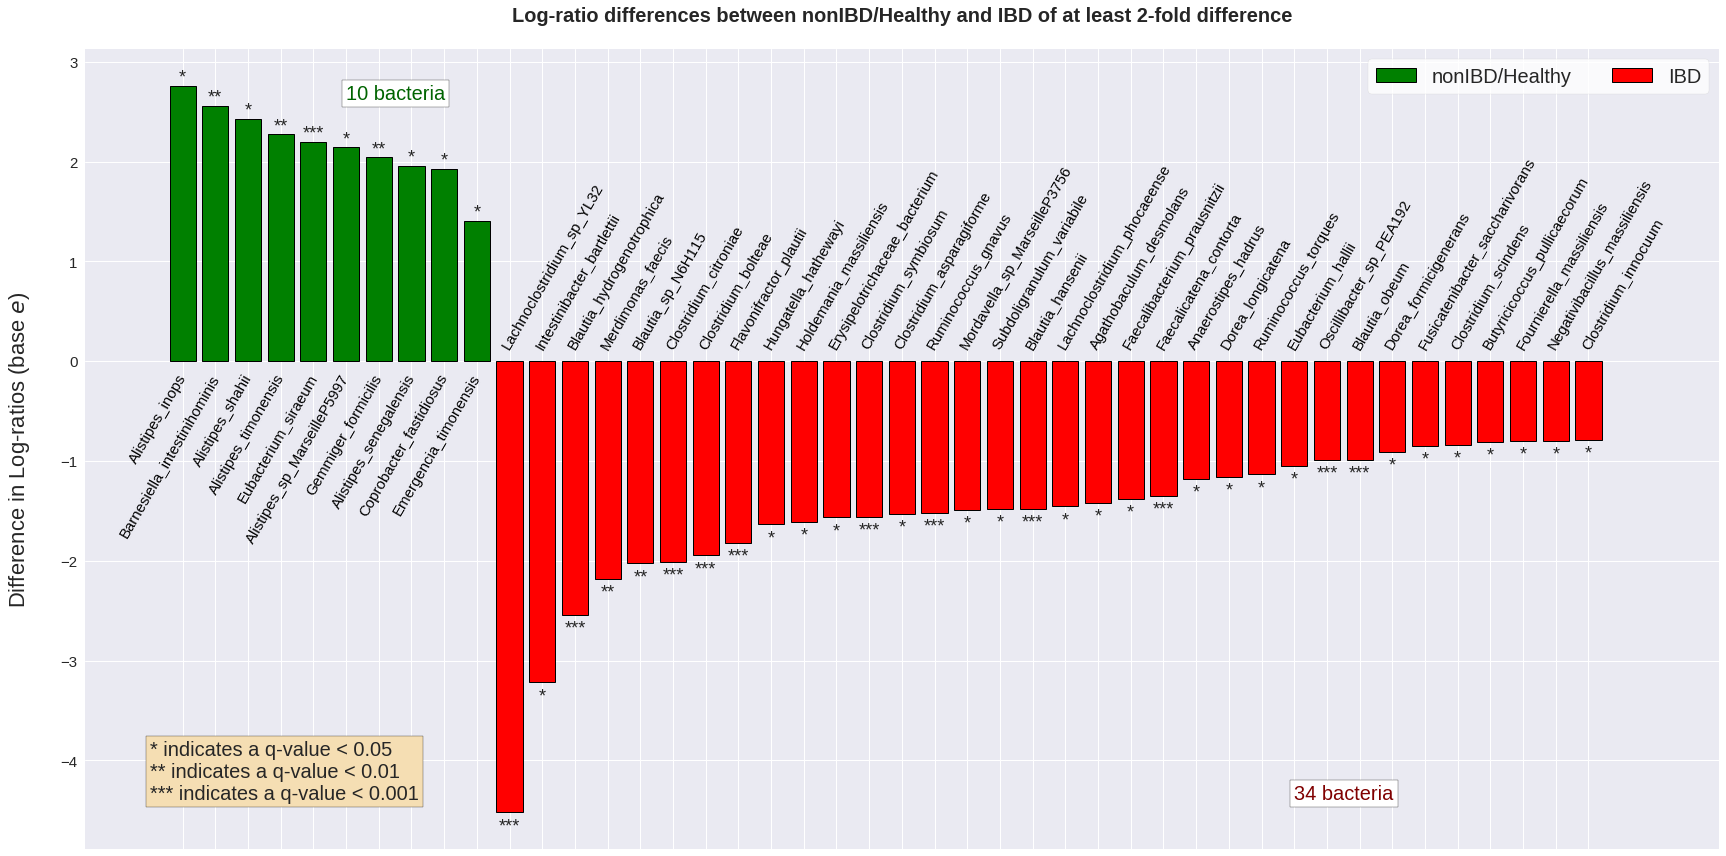

In [25]:
DiffViz(stat_ibd_others[["nonIBD/Healthy_mean", "IBD_mean", "Q_value"]], fold_diff_thresh=2)

# Network analysis

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import statistics
import math

from tqdm.notebook import tqdm as tqdm_nb
from collections import Counter

import os
import re

## Import the networks

In [27]:
def MakeNet(F, thresh=0.01):
    """
    Function to create the network object from the partical correlations matrix
    
    Parameters
    ----------
    F: Path to csv containing the partial correlation matrix
    
    Returns
    -------
    nx.Graph object
    
    """

    # Import matrix
    try:
        df = pd.read_csv(F, index_col="Unnamed: 0")
    except:
        try:
            df = pd.read_csv(F, index_col="Names")
        except:
            df = pd.read_csv(F)

    # Create an empty graph
    G = nx.Graph()

    # Iterate through the data to extract the nodes, edges, and weights
    for n1 in df.columns:
        for n2 in df.index:
            if abs(df.loc[n2,n1]) >= thresh and n2 != n1:
                if abs(df.loc[n2,n1]) != 0:
                    # Add weighted edge (wt) between node1 (n1) and node2 (n2)
                    G.add_edge(n1,n2, weight = df.loc[n2,n1])
                else:
                    G.add_edge(n1,n2, weight=0)
                
    non_zero_edges = [(e1,e2) for e1, e2, data in G.edges(data=True) if data["weight"] != 0]
                    
    print(f"{F.split('/')[-1].split('-')[0]}: N: {len(G.nodes)} E:{len(non_zero_edges)}")
    return G

In [28]:
ibdG = MakeNet('./DataFiles/IBD-trans_resultsPCorBootOmega.csv')
nibdG = MakeNet('./DataFiles/nonIBD-trans_resultsPCorBootOmega.csv')
hmpG = MakeNet('./DataFiles/HMP-trans_resultsPCorBootOmega.csv')
knsG = MakeNet('./DataFiles/KNS-trans_resultsPCorBootOmega.csv')

IBD: N: 66 E:96
nonIBD: N: 35 E:46
HMP: N: 58 E:122
KNS: N: 57 E:70


## Examine the Eigenvector Centrality (EVC)
- Eigenvector centrality (EVC) measures the influence a node has in a network by accounting for the connections of the node in question as well as the connections of its neighbors

In [29]:
def FindEigenCents(G, n=10):
    """
    Function to find the top-n nodes based on Eigenvector centrality (EVC)
    
    Parameters
    ----------
    G: nx.Graph object
    n: Integer specifying how many nodes to return
    
    Returns
    -------
    List containing top-n EVC nodes
    """
    
    from operator import itemgetter
    
    evc_dict = nx.eigenvector_centrality(G)
    top_evc = [x[0] for x in sorted(evc_dict.items(), key=itemgetter(1), reverse=True)[:n]]
    return top_evc

In [30]:
# Calculate the EVC's
ibd_evc = FindEigenCents(ibdG)
nibd_evc = FindEigenCents(nibdG)
kns_evc = FindEigenCents(knsG)
hmp_evc = FindEigenCents(hmpG)

In [32]:
# Import the label file; contains relative abundance labels (Elevated in IBD, Healthy, etc...)
labels = pd.read_csv("./DataFiles/DiffAbundanceList.csv", index_col="Unnamed: 0")

In [34]:
# All top-10 EVC's in IBD have relative abundances that are elevated in IBD
dict(labels.loc[ibd_evc].Status.value_counts())

{'Elevated in IBD': 10}

In [192]:
# Compare IBD top-10 EVC's to all the healthy groups
print("\nTop-10 EVC nodes only in IBD top-10 EVC")
print([x for x in ibd_evc if x not in nibd_evc \
and x not in kns_evc and x not in hmp_evc])

print("\nTop-10 EVC nodes only in Healthy top-10 EVC's")
print([x for x in nibd_evc if x not in ibd_evc \
and x in kns_evc and x in hmp_evc])


Top-10 EVC nodes only in IBD top-10 EVC
['Fusicatenibacter_saccharivorans']

Top-10 EVC nodes only in Healthy top-10 EVC's
[]


## Examine the average node degree by Genus

In [117]:
# Set up a color key for the genera to maintain the same coloring for each circle-plot
cdict = {"Others": "silver"}
color_cnt = 1 # To keep track of numbers for the color dict

def MakeDegPie(G, thresh=2):
    """
    Function to create pie chart of genera degrees
    
    Parameters
    ----------
    clust: DF slice containing only the cluster of interest
    thresh: Minimum percent abundance before lumping into 'Others' group (default: 2)
    title: String to specify title of plot
    
    Returns
    -------
    Pie plot of relative abundance of the genera within the cluster
    
    """
    from collections import Counter
    from operator import itemgetter
    from matplotlib import cm  
    
    # Create the color dictionary
    global cdict # use a global dict to ensure continuity for all pie plots
    global color_cnt

    gen_degs = {}
    
    for n,d in nx.degree(G):
        gen = n.split("_")[0]

        if gen in gen_degs.keys():
            gen_degs[gen] += d
        else:
            gen_degs[gen] = d
    
    # Sort the values by degree
    sorted_degs = {}
    for k in sorted(gen_degs, key=gen_degs.get, reverse=True):
        sorted_degs[k] = gen_degs[k]
    
    gen_degs = sorted_degs
    
    tot_counts = sum(gen_degs.values())
    new_genera = {"Others": 0}
    
    for g,c in gen_degs.items():
        pct = round((c/tot_counts) *100, 3)

        if pct >= thresh:
            new_genera[g] = pct
            if g in cdict.keys():
                pass
            else:
                cdict[g] = cm.jet(color_cnt * 25)
                color_cnt += 1
        else:
            new_genera["Others"] += pct
            
    
    global colors
    colors = [cdict[x] for x in new_genera.keys()]

    fig = plt.figure(1, figsize=(10,10), dpi=60)
    ax = fig.add_axes([0,0,1,1])

    explode = [0.05]
    for i in range(len(new_genera.keys()) - 1):
        explode.append(0)

    patches, texts, pct_labels = ax.pie(new_genera.values(), labels=new_genera.keys(), 
                            autopct="%.1f%%", pctdistance=0.8,
                            colors = colors, labeldistance=1.1, explode=explode,
                           wedgeprops=dict(linewidth=2, edgecolor='k', alpha=0.5),
                           textprops=dict(fontsize=15, color="k"))

    for l in pct_labels:
        l.set_backgroundcolor("white")
        l.set(bbox=dict(facecolor='w', edgecolor='k', boxstyle="round, pad=0.2"))
        l.set(fontsize=13)

Text(0.5, 1.0, 'Percent of connections by Genus in IBD network\n')

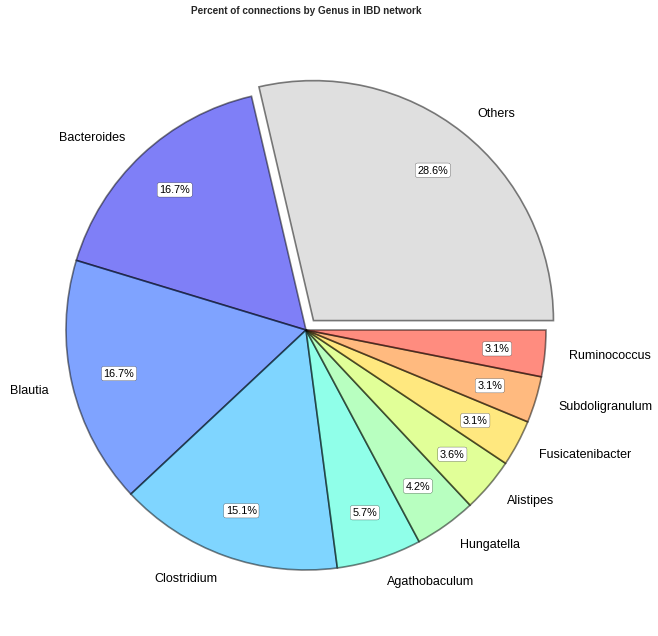

In [123]:
MakeDegPie(ibdG, thresh=3)
plt.title("Percent of connections by Genus in IBD network\n", weight='bold')

Text(0.5, 1.0, 'Percent of connections by Genus in non-IBD network\n')

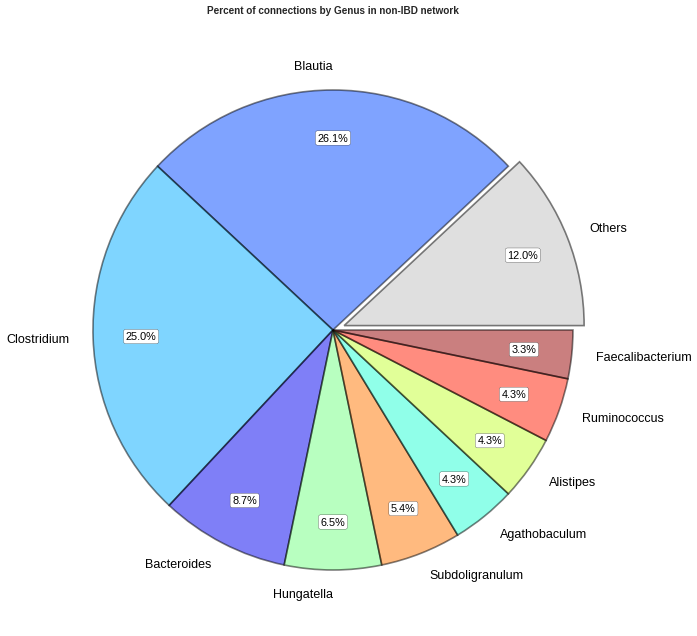

In [124]:
MakeDegPie(nibdG, thresh=3)
plt.title("Percent of connections by Genus in non-IBD network\n", weight='bold')

Text(0.5, 1.0, 'Percent of connections by Genus in Healthy-1 network\n')

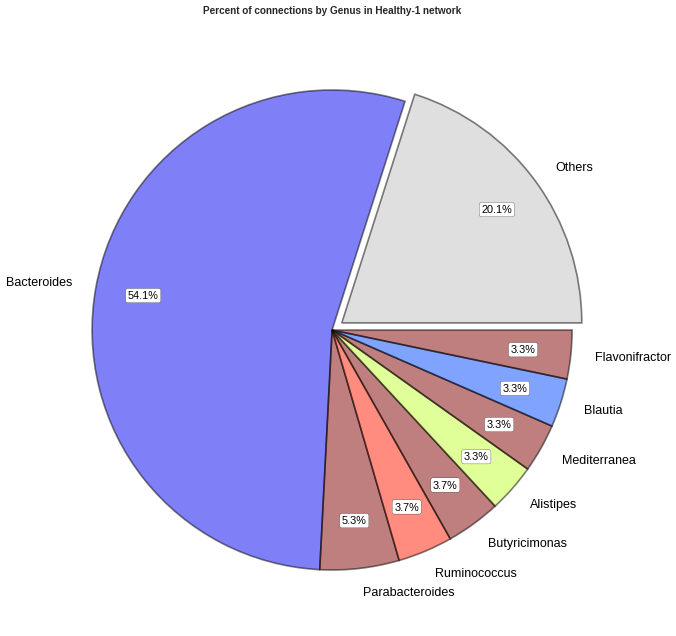

In [126]:
MakeDegPie(hmpG, thresh=3)
plt.title("Percent of connections by Genus in Healthy-1 network\n", weight='bold')

Text(0.5, 1.0, 'Percent of connections by Genus in Healthy-2 network\n')

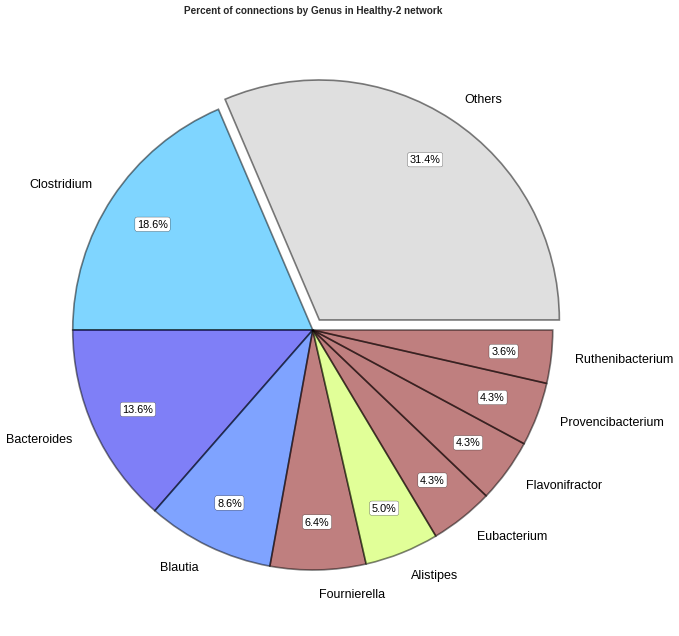

In [127]:
MakeDegPie(knsG, thresh=3)
plt.title("Percent of connections by Genus in Healthy-2 network\n", weight='bold')

## Compare node degree by realtive abundance status

In [193]:
def ExamineStatuses(G):
    """
    Quick function to look at relative abundance status counts (e.g. elevated in IBD, etc...)
    
    Parameters
    ----------
    G: nx.Graph object
    
    Returns
    -------
    DF object containing the results
    
    """
    
    stat_list = []
    for n in G.nodes:
        stat_list.append(labels.loc[n, "Status"])


    stat_df = pd.DataFrame.from_dict(dict(Counter(stat_list).most_common()), 
                                    orient='index', columns=["Count"])

    stat_df["Percent"] = stat_df.Count/stat_df.Count.sum()

    return stat_df

display(ExamineStatuses(ibdG))
display(ExamineStatuses(nibdG))
display(ExamineStatuses(hmpG))
display(ExamineStatuses(knsG))

,Count,Percent
Not significantly different,38,0.575758
Elevated in IBD,23,0.348485
Elevated in Healthy,5,0.075758


,Count,Percent
Not significantly different,18,0.514286
Elevated in IBD,15,0.428571
Elevated in Healthy,2,0.057143


,Count,Percent
Not significantly different,42,0.724138
Elevated in IBD,10,0.172414
Elevated in Healthy,6,0.103448


,Count,Percent
Not significantly different,35,0.614035
Elevated in IBD,20,0.350877
Elevated in Healthy,2,0.035088


In [194]:
x = np.mean(labels[labels.Status == "Not significantly different"].select_dtypes("float64").apply(lambda x:x.mean()))
print(f"Mean degree of samples that are NOT significantly different: {round(x,2)}")

x = np.mean(labels[labels.Status != "Not significantly different"].select_dtypes("float64").apply(lambda x:x.mean()))
print(f"Mean degree of samples that ARE significantly different: {round(x,2)}\n")

x = np.median(labels[labels.Status == "Not significantly different"].select_dtypes("float64").apply(lambda x:x.median()))
print(f"Median degree of samples that are NOT significantly different: {round(x,2)}")

x = np.median(labels[labels.Status != "Not significantly different"].select_dtypes("float64").apply(lambda x:x.median()))
print(f"Median degree of samples that ARE significantly different: {round(x,2)}")

Mean degree of samples that are NOT significantly different: 7.39
Mean degree of samples that ARE significantly different: 6.99

Median degree of samples that are NOT significantly different: 7.59
Median degree of samples that ARE significantly different: 6.98


In [195]:
def ExamineNegEdges(G):
    ibd_labels = labels[labels.Status == "Elevated in IBD"].index
    edges = [(e1,e2) for e1, e2, d in G.edges(data=True) if d["weight"] < 0]

    elevated_edges = [x for x in edges if x[0] in ibd_labels or x[1] in ibd_labels]
    try:
        print(f"{round(len(elevated_edges)/len(edges)*100,2)}% ({len(edges)}) \
of negative edges involve species elevated in IBD\n")
    except ZeroDivisionError:
        print("There are no negative edges!\n")

print("\nIBD network")
ExamineNegEdges(ibdG)

print("\nnon-IBD network")
ExamineNegEdges(nibdG)

print("\nHealthy-1 network")
ExamineNegEdges(hmpG)

print("\nHealthy-2 network")
ExamineNegEdges(knsG)


IBD network
85.71% (7) of negative edges involve species elevated in IBD


non-IBD network
100.0% (1) of negative edges involve species elevated in IBD


Healthy-1 network
There are no negative edges!


Healthy-2 network
100.0% (2) of negative edges involve species elevated in IBD



In [178]:
def ViewTops(G, top_list, print_neighbors=False):
    """
    Function to find the average edge weights of the top_list of nodes compared to other nodes

    Parameters
    ----------
    G: nx.Graph object
    top_list: list of nodes
    print_neighbors: Boolean to print out each node name and it's number of direct neighbors

    Returns
    -------
    DF object containing the results

    """
    
    weights = []
    non_weights = []
        
    for n in G.nodes:
        if print_neighbors:
            # Make the print out nicer
#             n = n.replace("\n", "_")
            string = f"{n} neighbors"
            print("-" * len(string))
            print(string)
            print("-" * len(string))

        # Correct the node names    
#         n = n.replace("_", "\n")

        # Extract the neighbors
        try:
#             print("Node: " + n.replace("\n", "_") + " neighbors: " + str(len(G[n])))
            for k,v in G[n].items():
                if n in top_list:
                    if print_neighbors:
#                         k = k.replace("\n", "_")
                        print(f"{k}: {v}")
                    else:
                        weights.append(v["weight"])
                
                else:
                    non_weights.append(v["weight"])
        except KeyError:
            pass
        
    deg_df = pd.DataFrame.from_dict(dict(G.degree), orient='index', columns=["degree"])
    found = {} # {node:degree}
         
    # Correct the node names
    for n in top_list:
        # Extract the degrees
        try:
            found[n] = int(deg_df.loc[n])
            
        except KeyError:
            pass
    
    # avg degree of non-top list nodes
    non_avg = deg_df.loc[[x for x in deg_df.index if x not in found]].degree.mean()
        
    results_cols = ["Group", "Average edge weight", "Average degree"]
    results = [["Elevated in IBD", round(np.mean(weights), 4), round(np.mean(list(found.values())), 3)],
              ["Non-elevated in IBD", round(np.mean(non_weights), 4), round(non_avg, 3)]]
    
    res_dict = {"Elevated in IBD":[round(np.mean(weights), 4), round(np.mean(list(found.values())), 3)],
              "Non-elevated in IBD": [round(np.mean(non_weights), 4), round(non_avg, 3)]}
    
    rdf = pd.DataFrame.from_dict(res_dict, columns=results_cols[1:], orient='index')
    
    # Print the results
    from tabulate import tabulate
    print(tabulate(results, headers=results_cols))
    
    return rdf

In [196]:
ibd_labels = list(labels[labels.Status == "Elevated in IBD"].index)

# Make a dict containing {graph_label:Graph}
Gdict = {"IBD":ibdG,
        "non-IBD": nibdG,
        "Healthy-1": hmpG,
        "Healthy-2": knsG}

# Instantiate a DF to concat on
rdf = pd.DataFrame()

for k,v in Gdict.items():
    print(f"\n\n\n{k} Graph")
    print("=" * (len(k) + 6))
    rdf0 = ViewTops(v, top_list=ibd_labels)
    rdf0["Graph"] = k
    rdf = pd.concat([rdf, rdf0])




IBD Graph
Group                  Average edge weight    Average degree
-------------------  ---------------------  ----------------
Elevated in IBD                     0.0595             5
Non-elevated in IBD                 0.0694             1.791



non-IBD Graph
Group                  Average edge weight    Average degree
-------------------  ---------------------  ----------------
Elevated in IBD                     0.0465             4.667
Non-elevated in IBD                 0.0609             1.1



Healthy-1 Graph
Group                  Average edge weight    Average degree
-------------------  ---------------------  ----------------
Elevated in IBD                     0.0699              4
Non-elevated in IBD                 0.0656              4.25



Healthy-2 Graph
Group                  Average edge weight    Average degree
-------------------  ---------------------  ----------------
Elevated in IBD                     0.0713             3.6
Non-elevated in IBD         

## Examine shared edges

In [177]:
def FindSharedEdges():
    """
    Function to spit out stats on the edges in the various groups
    """
        
    # We can be quicker with list comp, but we may lose some info (counts, and exact network names)
    global ibd_edges, nibd_edges, hmp_edges, kns_edges
    
    # Have to make the edges into strings to work with Counter properly
    ibd_edges = [f"{sorted(e)[0]} :: {sorted(e)[1]}" for e in ibdG.edges]
    nibd_edges = [f"{sorted(e)[0]} :: {sorted(e)[1]}" for e in nibdG.edges]
    hmp_edges = [f"{sorted(e)[0]} :: {sorted(e)[1]}" for e in hmpG.edges]
    kns_edges = [f"{sorted(e)[0]} :: {sorted(e)[1]}" for e in knsG.edges]
    
    
    # Edges that are not in IBD but are present in nonIBD and at least one healthy network
    global healthy_or_edges
    healthy_or_edges = [e for e in nibd_edges if e not in ibd_edges and e in hmp_edges or e in kns_edges]
    
    # Edges that are not in IBD but are present in nonIBD and are present in both healthy networks
    global healthy_and_edges
    healthy_and_edges = [e for e in nibd_edges if e not in ibd_edges and e in hmp_edges and e in kns_edges]
    
    # Edges that are shared in all networks
    global shared_edges
    shared_edges = [e for e in nibd_edges if e in ibd_edges and e in hmp_edges and e in kns_edges]
    
    # Edges that are only found in IBD
    global ibd_only_edges
    ibd_only_edges = [e for e in ibd_edges if e not in nibd_edges and e not in hmp_edges and e not in kns_edges]
    
    
    global all_edges
    all_edges = ibd_edges.copy()
    all_edges.extend(kns_edges)
    all_edges.extend(hmp_edges)
    all_edges.extend(nibd_edges)
    
    global edge_dict
    edge_dict = dict(Counter(all_edges).most_common())
    
    print(f"Union of associations from all groups: {len(edge_dict)}")
    print(f"Associations found only in IBD: {len(ibd_only_edges)}")
    print(f"Associations found in nonIBD and at least one other healthy cohort: {len(healthy_or_edges)}")
    print(f"Associations found only in healthy and found in all healthy cohorts: {len(healthy_and_edges)}")
    print(f"Associations found in all groups: {len(shared_edges)}")
        
FindSharedEdges()

Union of associations from all groups: 276
Associations found only in IBD: 58
Associations found in nonIBD and at least one other healthy cohort: 9
Associations found only in healthy and found in all healthy cohorts: 0
Associations found in all groups: 1


# Functional analysis

In [145]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import re
from tqdm.notebook import tqdm

from collections import Counter

from skbio.stats.composition import clr
import math
from statistics import mode
from scipy import stats

## Import the data

In [148]:
ibd_tigrs = pd.read_csv("DataFiles/ibd_tigrs.tsv", sep="\t", index_col="Unnamed: 0")
nibd_tigrs = pd.read_csv("DataFiles/nibd_tigrs.tsv", sep="\t", index_col="Unnamed: 0")
hmp_tigrs = pd.read_csv("DataFiles/hmp_tigrs.tsv", sep="\t", index_col="Unnamed: 0")
kns_tigrs = pd.read_csv("DataFiles/kns_tigrs.tsv", sep="\t", index_col="Unnamed: 0")

## Differential abundance analysis of TIGRFAM's

- Differential abundance analysis of the microbiome functions were performed using the TIGRFAM protein family database <sup>1</sup>

<br>

- **Framework**
    1. Group the TIGRFAM's by role
        * The TIGRFAM's relative abundances per sample have already been CLR-transformed
        * The sum is therefore of CLR-transformed values
    2. Compare the protein family roles in IBD vs control group using MWU

   
<br>
    
- Citations
    1. Haft, D H et al. “TIGRFAMs: a protein family resource for the functional identification of proteins.” Nucleic acids research vol. 29,1 (2001): 41-3. doi:10.1093/nar/29.1.41

In [175]:
def StatAnalysis(tigr1, tigr1_label, tigr2, tigr2_label, alpha=0.05):
    """
    Function to determine differentially abundant protien family roles
    
    Parameters
    ----------
    tigr1: DF containing the TIGRFAM's present in group 1
    tigr1_label: String specifying the name of group 1
    tigr2: DF containing the TIGRFAM's present in group 2
    tigr2_label: String specifying the name of group 2
    
    Returns
    -------
    DF object containing the results of the analysis
    
    """
    
    # Group the TIGRFAM's by assigned role
    temp1 = tigr1.groupby("Role").sum()
    tn1 = tigr1_label

    temp2 = tigr2.groupby("Role").sum()
    tn2 = tigr2_label
    
    res = {} # Prepare the dict to store the results in
    cols = [f"{tn1}_mean", f"{tn2}_mean", "p_val"] # Prepare the columns for the DF

    from scipy.stats import mannwhitneyu

    for i in temp1.index:
        m1 = temp1.loc[i].mean()
        m2 = temp2.loc[i].mean()

        u,p = mannwhitneyu(temp1.loc[i], temp2.loc[i])

        res[i] = [m1, m2, p]
    
    # Convert the dict into a DF
    rdf = pd.DataFrame.from_dict(res, orient="index", columns=cols)
    
    cnt = len(rdf[rdf.p_val < alpha])
    print(f"There are {cnt} significantly different TIGRFAMs")
    
    return rdf

There are 0 significantly different TIGRFAMs


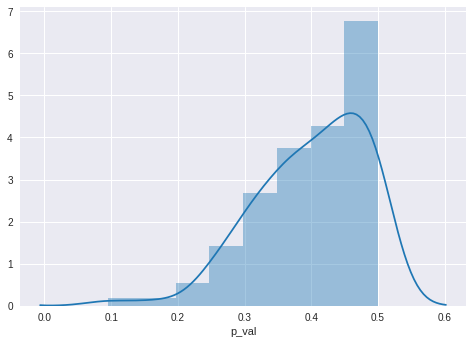

,IBD_mean,nonIBD_mean,p_val


In [151]:
alpha = 0.05
rdf0 = StatAnalysis(ibd_tigrs, "IBD", nibd_tigrs, "nonIBD")

sns.distplot(rdf0.p_val)
plt.show()

rdf0[rdf0.p_val < alpha]

There are 8 significantly different TIGRFAMs


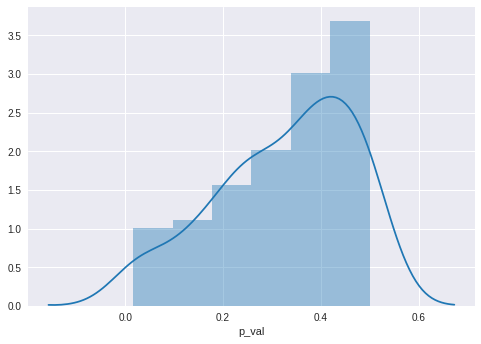

,IBD_mean,Healthy-2_mean,p_val
"Biosynthesis of cofactors, prosthetic groups, and carriers::Menaquinone and ubiquinone",13.036062,14.924005,0.025054
"Biosynthesis of cofactors, prosthetic groups, and carriers::Molybdopterin",4.993085,4.276544,0.033761
Cellular processes::Biosynthesis of natural products,76.764891,76.328365,0.018220
Cellular processes::Sporulation and germination,297.359509,290.297613,0.007957
DNA metabolism::Other,1.111432,0.609993,0.024403
Energy metabolism::Biosynthesis and degradation of polysaccharides,24.364295,18.463403,0.020077
Regulatory functions::Protein interactions,17.752179,16.150047,0.027547
Signal transduction::PTS,11.118389,9.203836,0.014283


In [168]:
alpha = 0.05
rdf1 = StatAnalysis(hmp_tigrs, "Healthy-1", ibd_tigrs, "IBD")

sns.distplot(rdf1.p_val)
plt.show()

rdf0[rdf1.p_val < alpha]

There are 8 significantly different TIGRFAMs


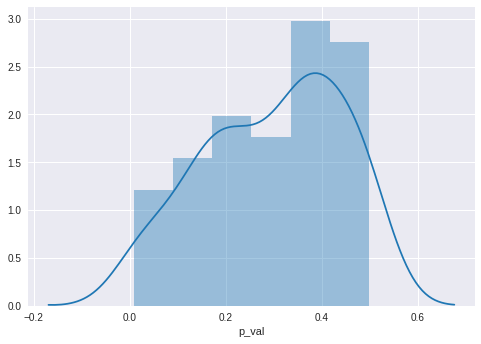

,Healthy-2_mean,IBD_mean,p_val
"Biosynthesis of cofactors, prosthetic groups, and carriers::Menaquinone and ubiquinone",14.924005,13.036062,0.025054
"Biosynthesis of cofactors, prosthetic groups, and carriers::Molybdopterin",4.276544,4.993085,0.033761
Cellular processes::Biosynthesis of natural products,76.328365,76.764891,0.018220
Cellular processes::Sporulation and germination,290.297613,297.359509,0.007957
DNA metabolism::Other,0.609993,1.111432,0.024403
Energy metabolism::Biosynthesis and degradation of polysaccharides,18.463403,24.364295,0.020077
Regulatory functions::Protein interactions,16.150047,17.752179,0.027547
Signal transduction::PTS,9.203836,11.118389,0.014283


In [169]:
alpha = 0.05
rdf2 = StatAnalysis(kns_tigrs, "Healthy-2", ibd_tigrs, "IBD")

sns.distplot(rdf2.p_val)
plt.show()

rdf2[rdf0.p_val < alpha]

In [170]:
# Find the differences that occur between IBD and both cohorts
external_diffs = [x for x in rdf1[rdf1.p_val < 0.05].index if x in rdf2[rdf2.p_val < 0.05].index]

display(rdf1.loc[external_diffs])
display(rdf2.loc[external_diffs])

,Healthy-1_mean,IBD_mean,p_val
"Biosynthesis of cofactors, prosthetic groups, and carriers::Menaquinone and ubiquinone",15.386819,13.036062,0.036593
"Biosynthesis of cofactors, prosthetic groups, and carriers::Molybdopterin",3.697802,4.993085,0.021341
Cellular processes::Biosynthesis of natural products,76.291660,76.764891,0.035786
Cellular processes::Sporulation and germination,289.369355,297.359509,0.016064
DNA metabolism::Other,0.550322,1.111432,0.028452
Energy metabolism::Biosynthesis and degradation of polysaccharides,17.788775,24.364295,0.035793
Regulatory functions::Protein interactions,15.839144,17.752179,0.032039
Signal transduction::PTS,8.913744,11.118389,0.019887


,Healthy-2_mean,IBD_mean,p_val
"Biosynthesis of cofactors, prosthetic groups, and carriers::Menaquinone and ubiquinone",14.924005,13.036062,0.025054
"Biosynthesis of cofactors, prosthetic groups, and carriers::Molybdopterin",4.276544,4.993085,0.033761
Cellular processes::Biosynthesis of natural products,76.328365,76.764891,0.018220
Cellular processes::Sporulation and germination,290.297613,297.359509,0.007957
DNA metabolism::Other,0.609993,1.111432,0.024403
Energy metabolism::Biosynthesis and degradation of polysaccharides,18.463403,24.364295,0.020077
Regulatory functions::Protein interactions,16.150047,17.752179,0.027547
Signal transduction::PTS,9.203836,11.118389,0.014283


In [171]:
# Combine and average the fold-diff of the features that are different between IBD and both healthy cohorts
ex_rdf = rdf1.copy().rename(columns={"Healthy-1_mean":"Healthy_mean"})

ex_rdf.Healthy_mean = (ex_rdf.Healthy_mean + rdf2["Healthy-2_mean"])/2

ex_rdf = ex_rdf[ex_rdf.p_val < 0.05]
ex_rdf

,Healthy_mean,IBD_mean,p_val
"Biosynthesis of cofactors, prosthetic groups, and carriers::Menaquinone and ubiquinone",15.155412,13.036062,0.036593
"Biosynthesis of cofactors, prosthetic groups, and carriers::Molybdopterin",3.987173,4.993085,0.021341
Cellular processes::Biosynthesis of natural products,76.310012,76.764891,0.035786
Cellular processes::Sporulation and germination,289.833484,297.359509,0.016064
DNA metabolism::Other,0.580158,1.111432,0.028452
Energy metabolism::Biosynthesis and degradation of polysaccharides,18.126089,24.364295,0.035793
Regulatory functions::Protein interactions,15.994595,17.752179,0.032039
Signal transduction::PTS,9.058790,11.118389,0.019887


In [172]:
def DiffViz(df, alpha=0.05, fold_diff_thresh=1, out=None, save=False, dpi=200, fc_df_out=False):
    """
    Function to calculate and visualize top-20 differences between the ILR-transformed data
    
    Paramters
    ---------
    df: Dataframe containing the statistical analysis
    alpha: q-value cut-off for significance
    fold_diff_thresh: Absolute value for minimum fold difference
    title_label: String for image title
    out: String specifying the image name
    save: Boolean for saving the image
    dpi: Integer specifiying the image DPI
    fc_df_out: Boolean to return the fold-change df
    
    Returns
    -------
    Image display (Top-n differencnes with q-val > alpha and diff > thresh)
    Saved image
    fc_df: fold-change DF containg only the significantly different Fold-Changes
    """
    
    global wdf
    wdf = df.copy() #working df
    diff_thresh = math.log(fold_diff_thresh)
            
    ######################Create the diffs (log fold-change)#####################################
    #1: find the rows containing the means
    rm = re.compile("_mean")
    mean_list = list(filter(rm.search,list(wdf.columns)))

    g1, g2 = mean_list #Store the groups into variables for easy use

    #2: Find the differences
    wdf["Diff"] = wdf.apply(lambda x:x[g1] - x[g2]\
                                     if x[g1]-x[g2] != 0\
                                     else 0, axis=1)
#     wdf["Diff"] = math.e ** wdf.Diff
    
    wdf["abs"] = abs(wdf["Diff"])
    wdf.sort_values(by='abs', ascending=False, inplace=True)
    wdf.drop("abs", axis=1, inplace=True)
    
    fc_df = wdf[wdf.p_val < alpha]
    
    ##################Create the fold-change graph##############################################
    mask1 = fc_df.Diff > diff_thresh #Higher in HMP -- Lower in IBD
    mask2 = fc_df.Diff < -1*diff_thresh #Lower in HMP -- Higher in IBD
    
    #Draw the graph labels
    name1 = g1.split("_")[0]
    name2 = g2.split("_")[0]
    
    plt.figure(figsize=(22,20))
    
    plot_len = len(fc_df[mask1].index) + len(fc_df[mask2].index) + 3 # Make this the length of the plot
    plt.xlim(-3, plot_len)
    plt.bar(fc_df.index[mask1], fc_df.Diff[mask1], color='green', 
            label=name1, edgecolor='black', linewidth=1)
    plt.bar(fc_df.index[mask2], fc_df.Diff[mask2], color='red', 
            label=name2, edgecolor='black', linewidth=1)
    
    
    plt.title(f"Log-ratio differences between {name1} and {name2} of at least {fold_diff_thresh}-fold difference\n", 
              size=20)
    plt.ylabel(r"Difference in Log-ratios (base $e$)"+"\n", size=22)
    
    #Remove the x-ticks
    plt.tick_params(axis='x', bottom=False, labelbottom=False)
    
    #Draw the labels and asterisks on the graph
    #Pos labels
    x = 0.2
    for i in fc_df[mask1].index:
        plt.annotate(i.replace("::", "\n"), xy=(x,-0.1), rotation=60, ha='right', va='top',\
                color='k', size=15)
            
        
        #Add q-value asterisks
        q = fc_df.loc[i]["p_val"]
        y = fc_df.loc[i]["Diff"]
        
        if q < 0.001:
            s = "***"
        elif q < 0.01:
            s = "**"
        else:
            s = "*"
        
        plt.annotate(s, xy=(x-0.2,y), ha='center', va='bottom', size=18)
        
        x+=1
        
        
    #Neg labels
    for i in fc_df[mask2].index:
        plt.annotate(i.replace("::", "\n"), xy=(x-0.5,0.1), rotation=60, ha='left', va='bottom',\
                color='k', size=15)

        #Add q-value asterisks
        q = fc_df.loc[i]["p_val"]
        y = fc_df.loc[i]["Diff"]
        
        if q < 0.001:
            s = "***"
        elif q < 0.01:
            s = "**"
        else:
            s = "*"
        
        plt.annotate(s, xy=(x-0.2,y-0.05), ha='center', va='top', size=18)
        
        x+=1
    
    
    # Label how many bacs are up, and how many are down
    xmin, xmax, ymin, ymax  = plt.axis()
    
#     plt.text(x=len(fc_df[mask1].index)/2, y=ymax-0.5, s=f"{len(fc_df[mask1])} bacteria", 
#              color='darkgreen', size=20, bbox={"facecolor":"white", "edgecolor":"k"})
    
#     plt.text(x=len(fc_df[mask2].index), y=ymin+0.5, s=f"{len(fc_df[mask2])} bacteria", 
#              color='maroon', size=20, bbox={"facecolor":"white", "edgecolor":"k"})
    
    #Add note explaining the q-value asterisks
    plt.text(x=xmin+0.1, y=ymin+0.5, s="""* indicates a p-value < 0.05
** indicates a p-value < 0.01
*** indicates a p-value < 0.001""", 
             bbox={'facecolor':'wheat', "edgecolor":"k"}, size=20)
    
    #Set up the save-option
    plt.tight_layout()
    
    if save:
        if not out:
            print("Out name required if you wish to save image")
        else:
            print("Image saved as '{}'".format(out))
            plt.savefig(out, dpi=dpi)
    
    plt.xticks(size=15)
    plt.yticks(size=15)
    
    plt.ylim(ymin, ymax+2)
    
    plt.legend(frameon=True, facecolor="white", 
              prop={"size":20})
#     plt.show()
    
    if fc_df_out:
        return fc_df

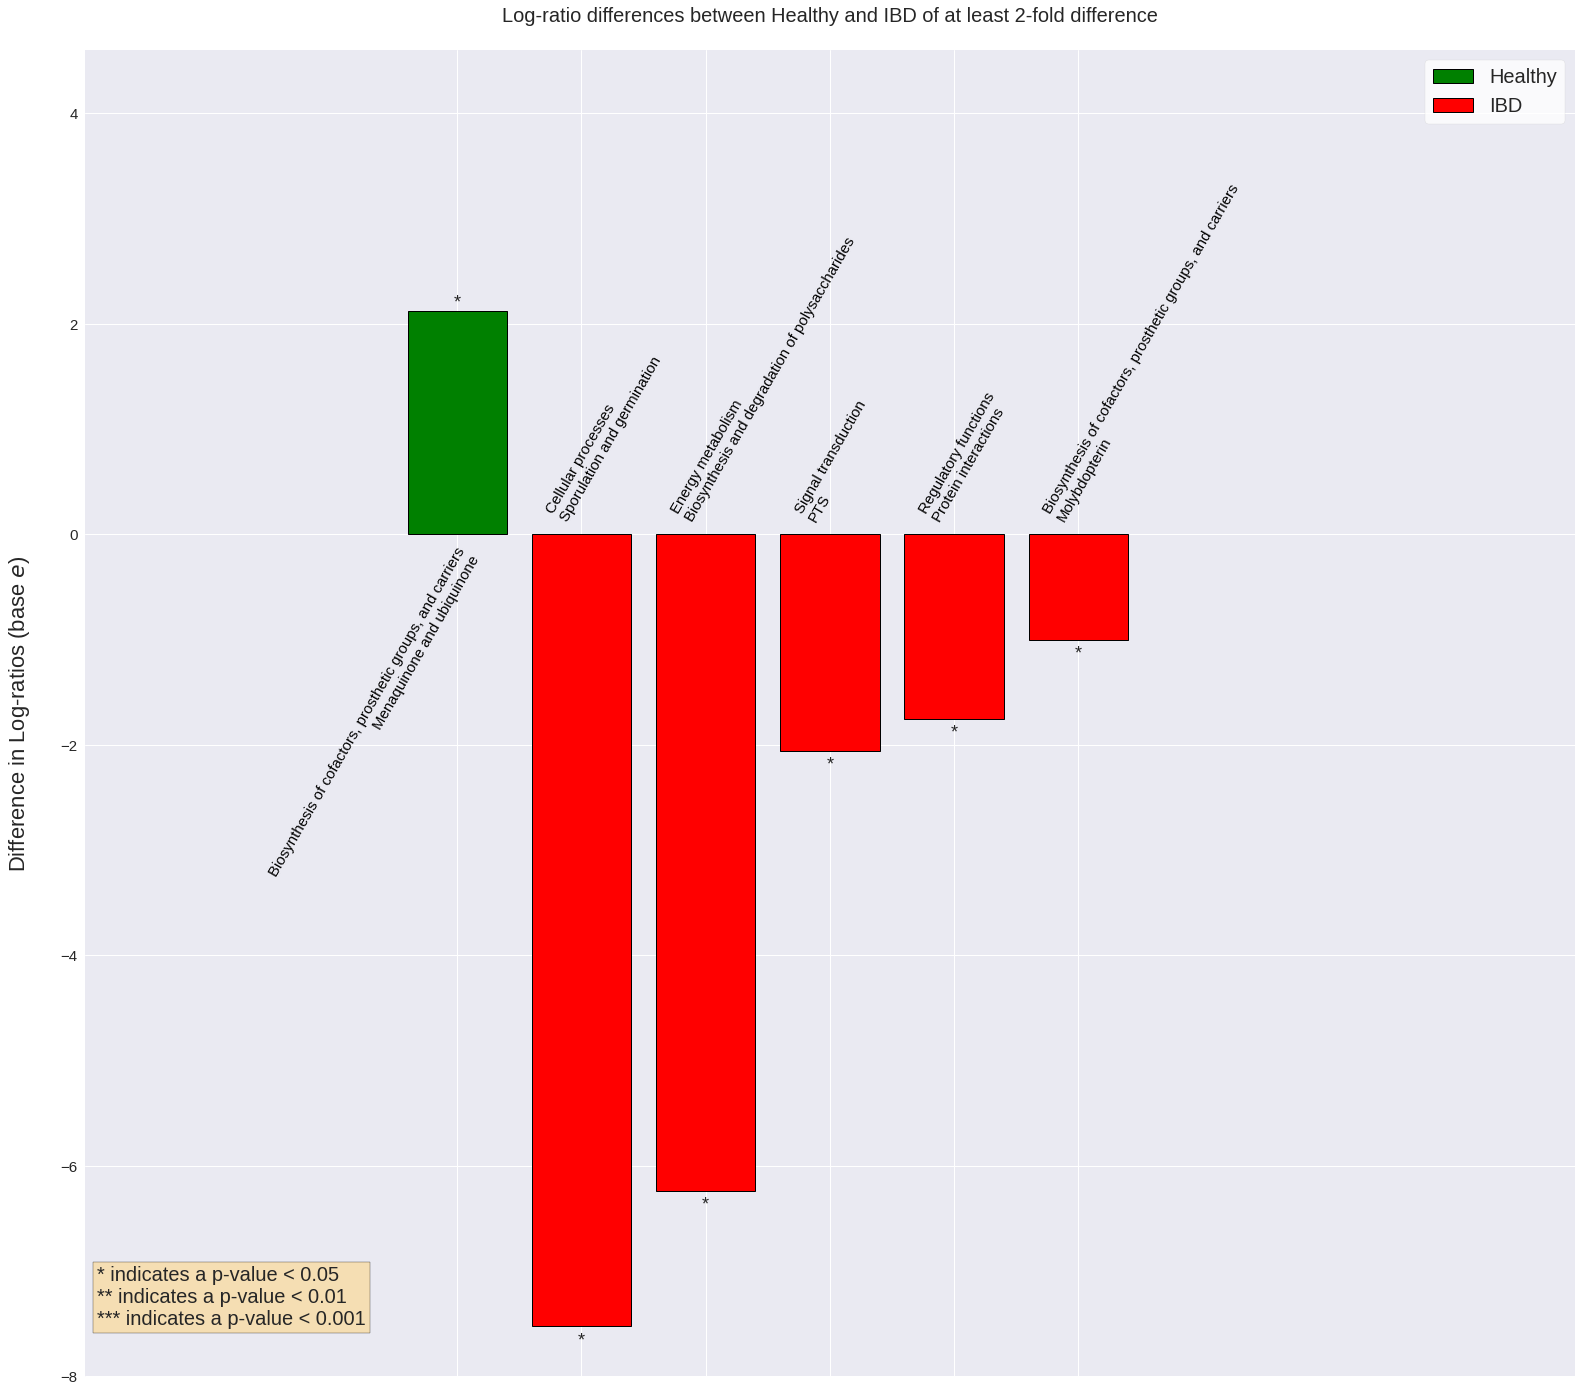

In [173]:
DiffViz(ex_rdf, fold_diff_thresh=2)